#Tag Prediction

In [ ]:
%pip install jsonlines

In [ ]:
%shell python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
# Import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import spacy
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from wordcloud import WordCloud
EN = spacy.load('en_core_web_sm')
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
import nltk
import inflect
from nltk.corpus import stopwords

def tokenize_text(text):
    "Apply tokenization using spacy to docstrings."
    tokens = EN.tokenizer(text)
    return [token.text.lower() for token in tokens if not token.is_space]

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def normalize(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

def tokenize_code(text):
    "A very basic procedure for tokenizing code strings."
    return RegexpTokenizer(r'\w+').tokenize(text)

def preprocess_text(text):
    return ' '.join(normalize(tokenize_text(text)))

In [ ]:
def document_generator(file, type="document"):
    # preprocessor = Preprocessor()
    use_stopwords = True
    if type == "string":
        use_stopwords = False

    with jsonlines.open(file) as reader:
        for doc_id, obj in enumerate(reader):
            # if not obj['tags'] == ["reddit"]:
            item = {
                'doc_id': doc_id,
                'url': obj['url'],
                'original_title':obj['title'],
                'title': preprocess_text(obj['title']),
                'desc': preprocess_text(obj['desc']),
                'votes': obj['votes'],
                'date': obj['date'],
                'answers': obj['answers'],
                'src': obj['src'],
                'tags': ", ".join(obj['tags']),
                # for answers
                'content': preprocess_text(obj['content']),
            }
            if type == "document":
                yield item
            elif type == "word_list":
                yield (item['title'] + " " + item['body']).split(" ")
            elif type == "string":
                yield item['title'] + " " + item['body']

In [ ]:
import jsonlines
data = pd.DataFrame(document_generator("data.jsonl", type="document"))

In [ ]:
data["text"] = data['title']+" "+data['desc'] + " " +data['content']
data.head()

,doc_id,url,original_title,title,desc,votes,date,answers,src,tags,content,text
0,0,https://askubuntu.com/questions/17823,How to list all installed packages,list installed packages,like output list installed packages text file ...,2184,2010-12-17 02:08:49,23,https://askubuntu.com/,"apt, package-management",already answered herehttpaskubuntucom question...,list installed packages like output list insta...
1,1,https://askubuntu.com/questions/86849,How to unzip a zip file from the Terminal?,unzip zip file terminal,downloaded zip file internet want use terminal...,1657,2011-12-11 04:37:54,9,https://askubuntu.com/,"command-line, zip",burtsevyg backslash necessary make shell treat...,unzip zip file terminal downloaded zip file in...
2,2,https://askubuntu.com/questions/307,How can PPAs be removed?,ppas removed,added many ppas using command simple way remov...,1362,2010-07-29 09:09:42,26,https://askubuntu.com/,"ppa, apt",advise try search unnecessary delrm rf one one...,ppas removed added many ppas using command sim...
3,3,https://askubuntu.com/questions/40779,How do I install a .deb file via the command l...,install deb file via command line,install file via command line,1197,2011-05-06 17:40:28,10,https://askubuntu.com/,"command-line, software-installation, dpkg, deb",related let dpkg install dependencies mehttpsa...,install deb file via command line install file...
4,4,https://askubuntu.com/questions/15433,Unable to lock the administration directory (/...,unable lock administration directory var lib d...,get error trying use e could get lock var lib ...,1090,2010-11-30 02:12:48,24,https://askubuntu.com/,"apt, package-management, dpkg",ok problem deal nt notice updates available in...,unable lock administration directory var lib d...


#checkpoint

In [ ]:
data.to_csv("file.csv")

In [ ]:
data = pd.read_csv("file.csv")
data.head()

,Unnamed: 0,doc_id,url,original_title,title,desc,votes,date,answers,src,tags,content,text
0,0,0,https://askubuntu.com/questions/17823,How to list all installed packages,list installed packages,like output list installed packages text file ...,2184,2010-12-17 02:08:49,23,https://askubuntu.com/,"['apt', ' package-management']",already answered herehttpaskubuntucom question...,list installed packages like output list insta...
1,1,1,https://askubuntu.com/questions/86849,How to unzip a zip file from the Terminal?,unzip zip file terminal,downloaded zip file internet want use terminal...,1657,2011-12-11 04:37:54,9,https://askubuntu.com/,"['command-line', ' zip']",burtsevyg backslash necessary make shell treat...,unzip zip file terminal downloaded zip file in...
2,2,2,https://askubuntu.com/questions/307,How can PPAs be removed?,ppas removed,added many ppas using command simple way remov...,1362,2010-07-29 09:09:42,26,https://askubuntu.com/,"['ppa', ' apt']",advise try search unnecessary delrm rf one one...,ppas removed added many ppas using command sim...
3,3,3,https://askubuntu.com/questions/40779,How do I install a .deb file via the command l...,install deb file via command line,install file via command line,1197,2011-05-06 17:40:28,10,https://askubuntu.com/,"['command-line', ' software-installation', ' d...",related let dpkg install dependencies mehttpsa...,install deb file via command line install file...
4,4,4,https://askubuntu.com/questions/15433,Unable to lock the administration directory (/...,unable lock administration directory var lib d...,get error trying use e could get lock var lib ...,1090,2010-11-30 02:12:48,24,https://askubuntu.com/,"['apt', ' package-management', ' dpkg']",ok problem deal nt notice updates available in...,unable lock administration directory var lib d...


# Checking w2v

In [ ]:
import gensim

# Parameters 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# Collect corpus for training word embeddings
documents = [_text.split() for _text in np.array(data.text)]  # I used the entire corpus for training, because it contains the entire conversation of related to a user's posts

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)
# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

# w2v_model.save('SO_word2vec_embeddings.bin')
w2v_model.save('word2vec.model')


Vocab size 17013


In [ ]:
# Testing Word Embeddings
print('Terms most similar to "django"')
print(w2v_model.wv.most_similar("django"))
print('-'*100)

print('Terms most similar to "api"')
print(w2v_model.wv.most_similar("api"))
print('-'*100)

print('Terms most similar to "benzene"')
print(w2v_model.wv.most_similar("benzene"))
print('-'*100)

print('Terms most similar to "server"')
print(w2v_model.wv.most_similar("server"))

Terms most similar to "django"
[('queryset', 0.44693323969841003), ('sqlalchemy', 0.40048789978027344), ('rails', 0.3596212565898895), ('orm', 0.350703626871109), ('stylesheets', 0.34415239095687866), ('eloquent', 0.3267546594142914), ('mvc', 0.31121131777763367), ('jboss', 0.3026029169559479), ('401', 0.29861754179000854), ('aspnet', 0.2951045036315918)]
----------------------------------------------------------------------------------------------------
Terms most similar to "api"
[('apis', 0.39234551787376404), ('restful', 0.37219536304473877), ('servlet', 0.35211682319641113), ('httpclient', 0.3474002182483673), ('frontend', 0.3385322690010071), ('library', 0.3351450562477112), ('http', 0.33276909589767456), ('depcompareop', 0.3307284116744995), ('targetsdkversion', 0.32940784096717834), ('firebase', 0.32802021503448486)]
----------------------------------------------------------------------------------------------------
Terms most similar to "benzene"
[('cyclohexane', 0.49867802858

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Continue

In [ ]:
# Make a dict having tag frequencies
# data.tags = data.tags.apply(lambda x: x.split(','))
tag_freq_dict = {}
for tags in data.tags:
    for tag in tags:
        if tag not in tag_freq_dict:
            tag_freq_dict[tag] = 0
        else:
            tag_freq_dict[tag] += 1

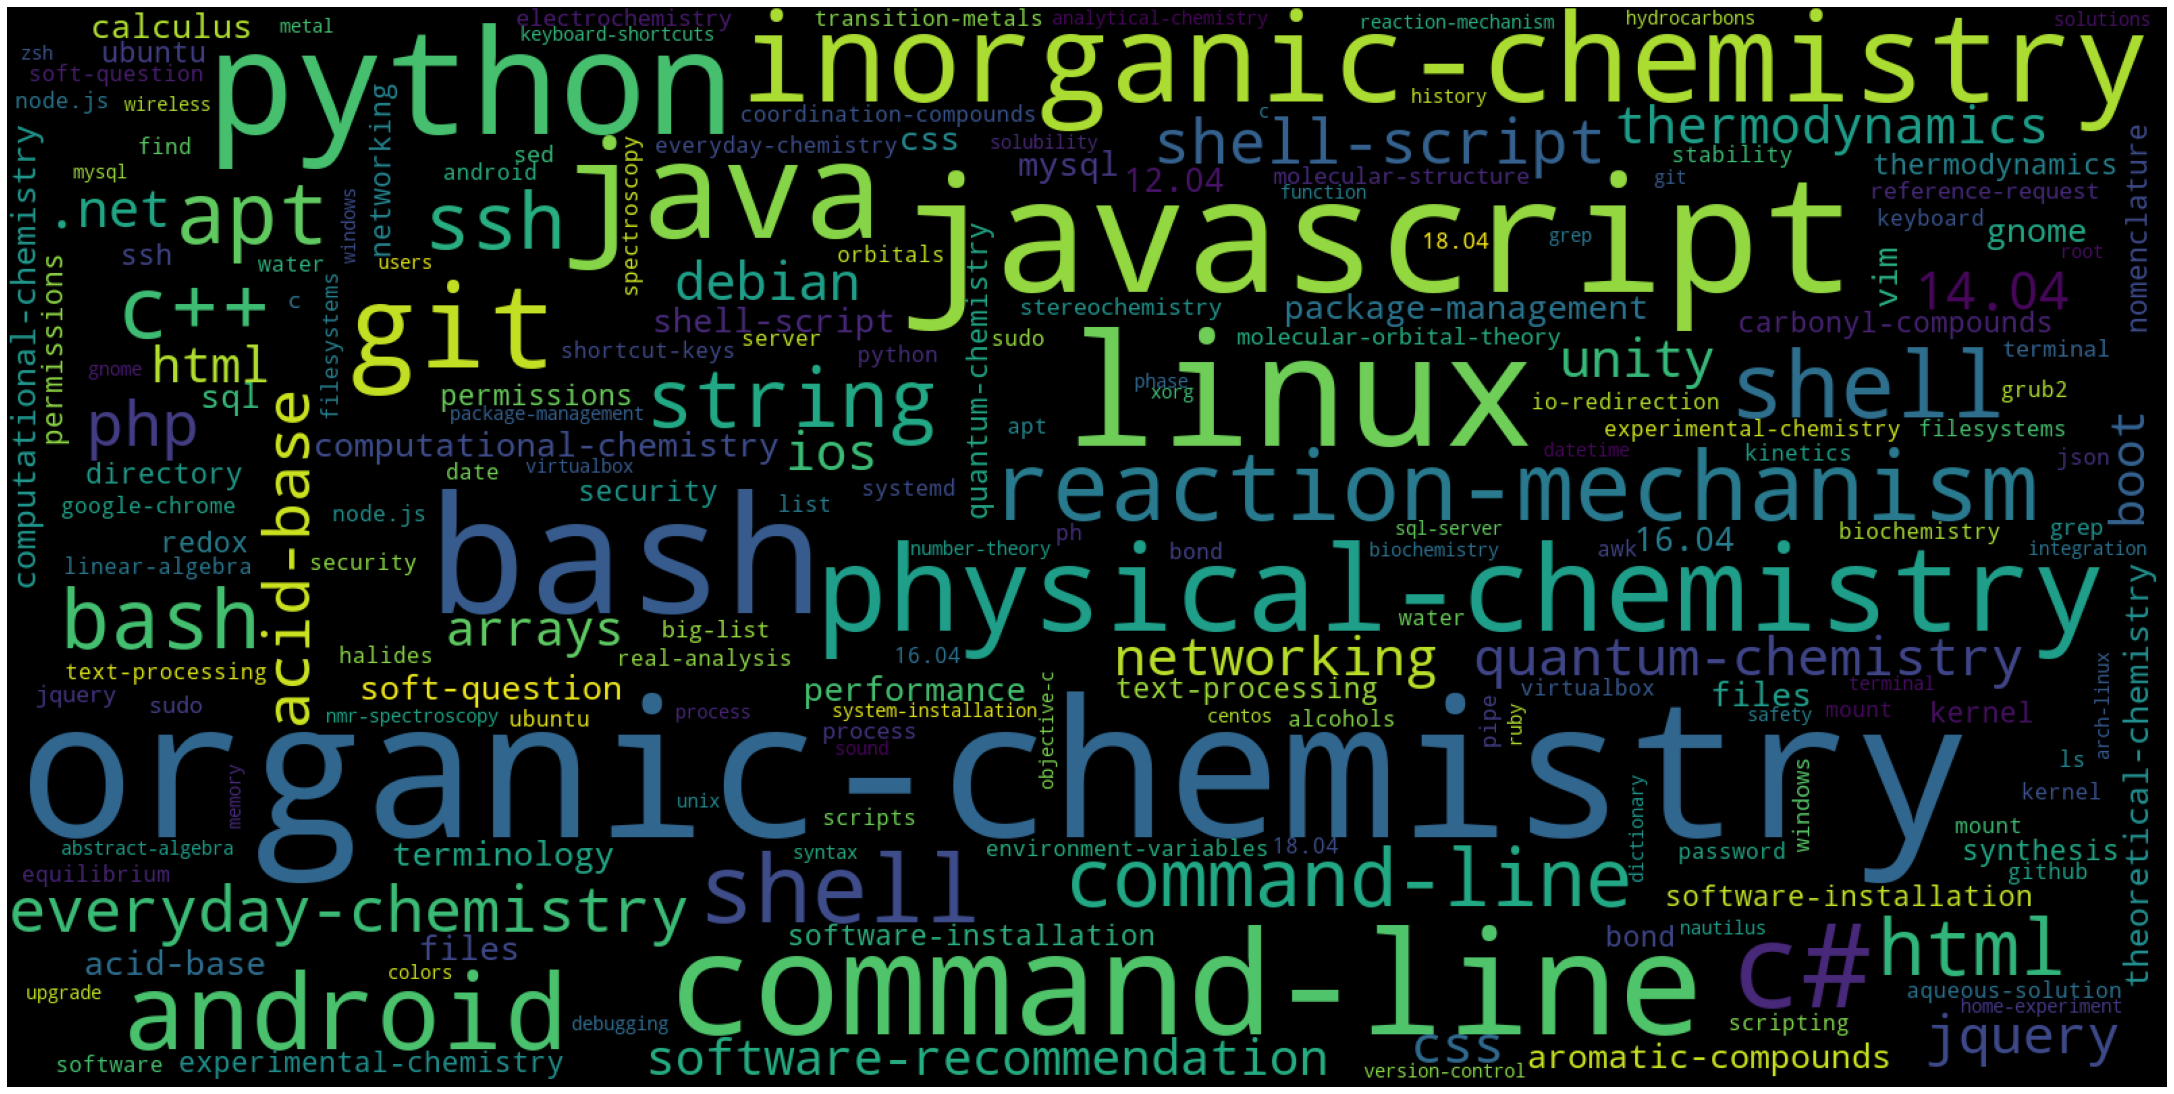

In [ ]:

# Visualize all tags based on their frequencies using a WordCloud
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tag_freq_dict)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# Get most common tags
tags_to_use = 500
tag_freq_dict_sorted = dict(sorted(tag_freq_dict.items(), key=lambda x: x[1], reverse=True))
final_tags = list(tag_freq_dict_sorted.keys())[:tags_to_use]
len(final_tags)

500

In [ ]:
# Change tag data to only for final_tags
final_tag_data = []
for tags in data.tags:
    temp = []
    for tag in tags:
        if tag in final_tags:
            temp.append(tag)
    final_tag_data.append(temp)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(final_tag_data)
tags_encoded.shape

(40102, 500)

In [ ]:
# Split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(data.title), tags_encoded, test_size=0.2, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 32081
TEST size: 8021


In [ ]:
# Tokenizing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.utils.np_utils import to_categorical

MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 300


tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

# saving
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


Found 188864 unique tokens.


In [ ]:
# loading tokenizer
import pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

Found 188864 unique tokens.


In [ ]:
# Convert the data to padded sequences
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)

Shape of data tensor: (32081, 300)


In [ ]:
# Embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(188865, 300)


In [ ]:
# Build Model
import keras 

model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(500, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units = 10000,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )  
model.add(Dropout(0.35))
model.add(Dense(units = 1150,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
model.add(Dropout(0.25))
model.add(Dense(units = 750,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
model.add(Dense(500, activation='sigmoid'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer="adam")
              
# Train Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5)]

BATCH_SIZE = 512
history = model.fit(X_train_padded, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

# Save model
model.save('tag_predictor.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          56659500  
_________________________________________________________________
lstm_3 (LSTM)                (None, 500)               1602000   
_________________________________________________________________
dense_12 (Dense)             (None, 10000)             5010000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 1150)              11501150  
_________________________________________________________________
dropout_7 (Dropout)          (None, 1150)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 750)              

In [ ]:
from keras.models import load_model
import keras.losses

# model = load_model('tag_predictor.h5')

{}


In [ ]:
history.history

{'loss': [7.450040817260742,
  5.736416816711426,
  5.099689960479736,
  4.6966753005981445,
  4.351944446563721],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001],
 'val_loss': [5.884893417358398,
  5.317706108093262,
  5.186737537384033,
  5.065468788146973,
  5.196690559387207]}

16/16 [==============================] - 4s 260ms/step - loss: 5.4863
LOSS: 5.486273765563965


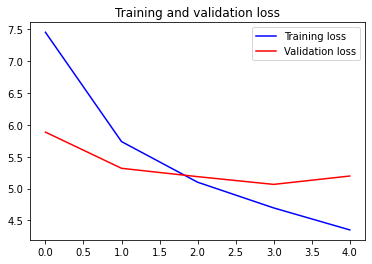

In [ ]:
# Evaluation
import matplotlib.pyplot as plt
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
score = model.evaluate(X_test_padded, y_test, batch_size=512)
print("LOSS:",score)

loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(loss))
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Predict Tags

In [ ]:
# A wrapper function in order to predict the tags for any given input

def predict_tags(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    prediction = model.predict([x_test])[0]
    for i,value in enumerate(prediction):
        if value > 0.5:
            prediction[i] = 1
        else:
            prediction[i] = 0
    tags = tag_encoder.inverse_transform(np.array([prediction]))
    return tags

In [ ]:

test_idx = np.random.randint(len(X_test), size=5)

for idx in test_idx:
    test_case = idx
    print('Test Case: ' + str(X_test[test_case]))
    print('-'*100)
    print('Predicted: ' + str(predict_tags(X_test[test_case])))
    print('Ground Truth: ' + str(tag_encoder.inverse_transform(np.array([y_test[test_case]]))))
    print('\n')

Test Case: setup keyboard macros
----------------------------------------------------------------------------------------------------
Predicted: [(' keyboard', ' keyboard-layout', ' shortcut-keys', 'keyboard', 'shortcut-keys')]
Ground Truth: [(' shortcut-keys', 'keyboard')]


Test Case: boot loader installed
----------------------------------------------------------------------------------------------------
Predicted: [(' dual-boot', ' grub2', 'boot')]
Ground Truth: [()]


Test Case: shell show typed commands reset works happened
----------------------------------------------------------------------------------------------------
Predicted: [(' command-history', ' zsh', 'bash', 'command-line')]
Ground Truth: [(' bash', 'command-line')]


Test Case: tcp dies linux laptop
----------------------------------------------------------------------------------------------------
Predicted: [('linux',)]
Ground Truth: [(' networking', 'debian')]


Test Case: reason decreased boiling point hexafluor